## Problem Definition

### Task
This is a **supervised regression** problem.

- **Target (y):** `Final_Price`  
- **Goal:** Predict a smartphone’s final price using its specifications and attributes.

### Features (X)
I use both numerical and categorical predictors:
- **Categorical:** `Brand`, `Model`, `Color`, `Free`
- **Numerical:** `RAM`, `Storage`

These features are chosen because phone pricing is typically influenced by brand/model identity, hardware capacity, product variants, and promotions.

### Evaluation metrics (why MAE and RMSE?)
I evaluate using:
- **MAE**: average absolute price error (easy to interpret as “typical error”)
- **RMSE**: penalizes large errors more (important when outliers exist)

For model selection, I prioritize **lower MAE**, and use RMSE to check whether a model makes occasional large mistakes.


## Load Dataset and Basic Inspection

Before EDA and modelling, I inspect the dataset to confirm:
1. the dataset loads correctly (`head()` / `tail()`),
2. the dataset size and column types (`shape`, `info()`),
3. which columns contain missing values (missing value summary).

This supports later decisions on preprocessing, feature engineering/selection, and model choice.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

In [26]:
FILE_PATH = 'smartphones.csv'
df = pd.read_csv(FILE_PATH)
df

,Smartphone,Brand,Model,RAM,Storage,Color,Free,Final Price
0,Realme C55 8/256GB Sunshower Libre,Realme,C55,8.0,256.0,Yellow,Yes,231.60
1,Samsung Galaxy M23 5G 4/128GB Azul Libre,Samsung,Galaxy M23,4.0,128.0,Blue,Yes,279.00
2,Motorola Moto G13 4/128GB Azul Lavanda Libre,Motorola,Moto G13,4.0,128.0,Blue,Yes,179.01
3,Xiaomi Redmi Note 11S 6/128GB Gris Libre,Xiaomi,Redmi Note 11S,6.0,128.0,Gray,Yes,279.99
4,Nothing Phone (2) 12/512GB Blanco Libre,Nothing,Phone (2),12.0,512.0,White,Yes,799.00
...,...,...,...,...,...,...,...,...
1811,Xiaomi Redmi Note 8 4/64GB Azul Libre,Xiaomi,Redmi Note 8,4.0,64.0,Blue,Yes,249.01
1812,Xiaomi Redmi Note 8T 4/128GB Azul Estelar Libre,Xiaomi,Redmi Note 8T,4.0,128.0,Blue,Yes,200.00
1813,Xiaomi Redmi Note 9 4/128GB Blanco Libre,Xiaomi,Redmi Note 9,4.0,128.0,White,Yes,269.00
1814,Xiaomi Redmi Note 9S 4/64GB Dual SIM Gris Libre,Xiaomi,Note 9S,4.0,64.0,Gray,Yes,211.00


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Smartphone   1816 non-null   object 
 1   Brand        1816 non-null   object 
 2   Model        1816 non-null   object 
 3   RAM          1333 non-null   float64
 4   Storage      1791 non-null   float64
 5   Color        1816 non-null   object 
 6   Free         1816 non-null   object 
 7   Final Price  1816 non-null   float64
dtypes: float64(3), object(5)
memory usage: 113.6+ KB


In [28]:
df.isna().sum() ##b Check missing values

Smartphone       0
Brand            0
Model            0
RAM            483
Storage         25
Color            0
Free             0
Final Price      0
dtype: int64

In [29]:
df.describe(include='all')

,Smartphone,Brand,Model,RAM,Storage,Color,Free,Final Price
count,1816,1816,1816,1333.00000,1791.000000,1816,1816,1816.000000
unique,1816,37,383,NaN,NaN,17,2,NaN
top,Realme C55 8/256GB Sunshower Libre,Samsung,iPhone 13,NaN,NaN,Black,Yes,NaN
freq,1,458,60,NaN,NaN,537,1772,NaN
mean,NaN,NaN,NaN,5.96099,162.652150,NaN,NaN,492.175573
std,NaN,NaN,NaN,2.66807,139.411605,NaN,NaN,398.606183
min,NaN,NaN,NaN,1.00000,2.000000,NaN,NaN,60.460000
25%,NaN,NaN,NaN,4.00000,64.000000,NaN,NaN,200.990000
50%,NaN,NaN,NaN,6.00000,128.000000,NaN,NaN,349.990000
75%,NaN,NaN,NaN,8.00000,256.000000,NaN,NaN,652.717500


In [30]:
# Clean column names
df.columns = [c.strip().replace(" ", "_") for c in df.columns]
df.columns


Index(['Smartphone', 'Brand', 'Model', 'RAM', 'Storage', 'Color', 'Free',
       'Final_Price'],
      dtype='object')

## Handling Missing Values (Before EDA)

### Why handle missing values first?
Missing values can break plots and scikit-learn models, and can bias analysis if handled inconsistently.  
Therefore, I handle missing values **before** EDA and model training.

### Imputation strategy (finalized preprocessing)
From inspection, the missing values are mainly in **`RAM`** and **`Storage`**.

- **Numerical (`RAM`, `Storage`) → Median**
  - Median is robust to outliers, which is common in pricing/spec datasets.
- **Categorical (`Brand`, `Model`, `Color`, `Free`) → Most frequent**
  - Preserves valid categories and avoids creating artificial labels.

### Why use a Pipeline?
I apply preprocessing inside a scikit-learn pipeline so:
- training and test data receive identical transformations,
- comparisons between models remain fair,
- the workflow is reproducible and reduces data leakage risk.


In [31]:
# ===== Handling Missing Values (Before EDA) =====

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Check missing values
df.isna().sum()

# Columns
num_cols = ["RAM", "Storage"]
cat_cols = ["Brand", "Model", "Color", "Free"]

# Pipelines
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocessor
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ]
)

preprocess


# Create an imputed copy for EDA plots (so NaNs do not distort plots)
df_eda = df.copy()
# Numeric imputation for EDA
for col in ["RAM", "Storage"]:
    if col in df_eda.columns:
        df_eda[col] = df_eda[col].fillna(df_eda[col].median())
# Categorical imputation for EDA (optional; mainly for completeness)
for col in ["Brand", "Model", "Color", "Free"]:
    if col in df_eda.columns:
        mode_val = df_eda[col].mode(dropna=True)
        if len(mode_val) > 0:
            df_eda[col] = df_eda[col].fillna(mode_val.iloc[0])


## Exploratory Data Analysis (EDA)

### Purpose
EDA is used to understand:
1. the distribution of `Final_Price` (skew / typical price range),
2. whether outliers exist (very expensive phones),
3. relationships between key predictors and price,
4. correlations between predictors (e.g., RAM vs Storage) that may affect linear models.

### Evidence and interpretation
- **Histogram (`Final_Price`)**: checks for skew and imbalance (e.g., many budget phones, fewer expensive phones).
- **Boxplot (`Final_Price`)**: highlights outliers that can increase RMSE.
- **Scatterplots (RAM/Storage vs Price)**: checks whether higher specs generally correspond to higher prices.
- **Correlation heatmap**: confirms which numerical features are related to price and whether predictors are correlated with each other.

These observations justify evaluating models with both **MAE** (typical error) and **RMSE** (sensitivity to large errors).


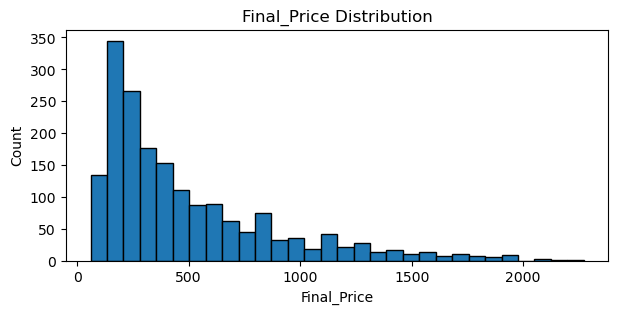

In [32]:
# Histogram of Final_Price
import matplotlib.pyplot as plt

plt.figure(figsize=(7,3))
plt.hist(df["Final_Price"], bins=30, edgecolor="black")
plt.title("Final_Price Distribution")
plt.xlabel("Final_Price")
plt.ylabel("Count")
plt.show()


Boxplot (Final_Price) → shows outliers (very expensive phones).

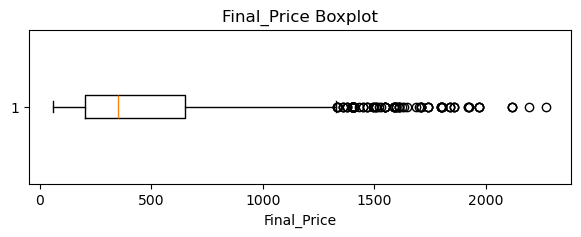

In [33]:
# Boxplot of Final_Price
plt.figure(figsize=(7,2))
plt.boxplot(df["Final_Price"], vert=False)
plt.title("Final_Price Boxplot")
plt.xlabel("Final_Price")
plt.show()


Scatter (RAM vs Final_Price) and Scatter (Storage vs Final_Price) → shows both have a positive relationship with price (good predictors)

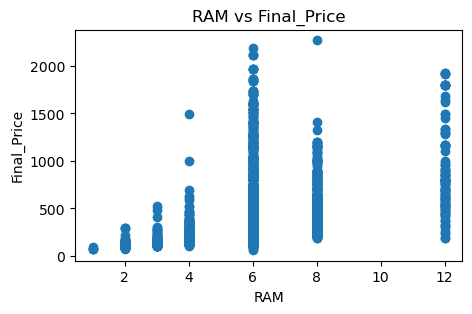

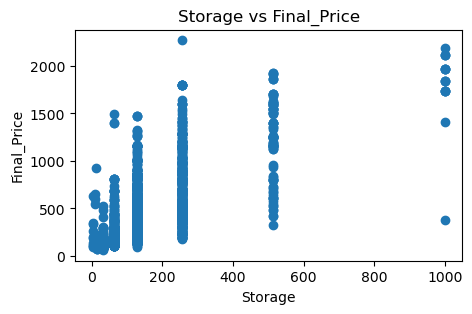

In [34]:
# Scatter plots of Final_Price against RAM and Storage
plt.figure(figsize=(5,3))
plt.scatter(df_eda["RAM"], df["Final_Price"])
plt.title("RAM vs Final_Price")
plt.xlabel("RAM")
plt.ylabel("Final_Price")
plt.show()

plt.figure(figsize=(5,3))
plt.scatter(df_eda["Storage"], df["Final_Price"])
plt.title("Storage vs Final_Price")
plt.xlabel("Storage")
plt.ylabel("Final_Price")
plt.show()


Correlation heatmap → confirms RAM/Storage correlate with price and with each other

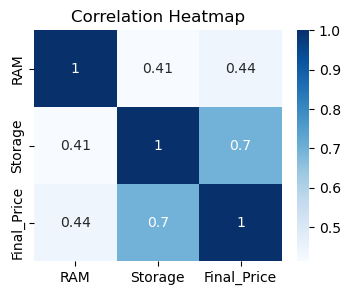

In [35]:
# Correlation heatmap
import seaborn as sns

corr = df_eda[["RAM", "Storage", "Final_Price"]].corr(numeric_only=True)
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()


## Train-Test Split + Baseline Model

1. I define features **X** using smartphone specs (`Brand`, `Model`, `RAM`, `Storage`, `Color`, `Free`) and set **y** as `Final_Price`.
2. I split the data into **train** and **test** sets so performance is evaluated on unseen data (avoids overly optimistic training-only evaluation).
3. I train a baseline model (**Linear Regression**) using a **Pipeline** (preprocessing + model) to ensure consistent transformations.
4. I evaluate using **MAE** and **RMSE** to establish a benchmark for later comparisons (other models, feature engineering/selection, and tuning).

**Evidence:** baseline MAE/RMSE on the test set.


In [36]:
# Define X and y
X = df[["Brand", "Model", "RAM", "Storage", "Color", "Free"]].copy()
y = df["Final_Price"].copy()

X.head(3)

,Brand,Model,RAM,Storage,Color,Free
0,Realme,C55,8.0,256.0,Yellow,Yes
1,Samsung,Galaxy M23,4.0,128.0,Blue,Yes
2,Motorola,Moto G13,4.0,128.0,Blue,Yes


In [37]:
#Train-test split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1452, 6) Test: (364, 6)


In [38]:
#Baseline model (LinearRegression) + Evaluation
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

baseline_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

baseline_pipe.fit(X_train, y_train)
pred_base = baseline_pipe.predict(X_test)

mae_base = mean_absolute_error(y_test, pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, pred_base))

results_base = pd.DataFrame([{
    "Model": "LinearRegression (Baseline)",
    "MAE": mae_base,
    "RMSE": rmse_base
}])

results_base


,Model,MAE,RMSE
0,LinearRegression (Baseline),116.776936,183.958763


## Step 9: Base Model vs Other Models (Model Comparison)

In this step, I compare the baseline model with other regression algorithms to identify the best performer for predicting `Final_Price`.

### Fair comparison controls
- Same **train-test split**
- Same **preprocessing pipeline**
- Same **metrics** (MAE and RMSE)

### Selection rule
I select the best model primarily by **lowest MAE** (most interpretable “typical price error”), and use **RMSE** as a secondary check to avoid models that make large occasional mistakes.

**Evidence:** a results table (Model | MAE | RMSE) on the test set.


In [39]:
# Base model vs other models 

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=200),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

results_compare = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))

    results_compare.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse
    })

results_compare = pd.DataFrame(results_compare).sort_values(["MAE", "RMSE"])
results_compare


,Model,MAE,RMSE
0,LinearRegression,116.776936,183.958763
2,RandomForest,117.900177,196.916968
1,Ridge,126.220644,193.292663
3,GradientBoosting,140.724179,207.858418


## Select Best Model

From the model comparison results, **LinearRegression** achieves the lowest **MAE** and **RMSE** on the test set, so it is selected as the current best model.

Next, I evaluate whether feature engineering improves performance by comparing:
- **LinearRegression (before feature engineering)** vs  
- **LinearRegression (after feature engineering)**

using the same split, the same preprocessing approach, and the same evaluation metrics.

**Evidence:** a before/after feature engineering table (MAE/RMSE).


In [40]:
# Select best model 
best_model_name = results_compare.iloc[0]["Model"]
best_model_name


'LinearRegression'

In [41]:
# Feature engineering

df_fe = df.copy()

# 1) Convert Free (Yes/No) -> numeric 1/0
df_fe["Free_bin"] = df_fe["Free"].astype(str).str.strip().str.lower().map({"yes": 1, "no": 0})

# 2) Interaction feature: RAM * Storage (combined effect)
df_fe["RAM_x_Storage"] = df_fe["RAM"] * df_fe["Storage"]

# 3) Ratio feature: Storage per RAM (value/performance style indicator)
df_fe["Storage_per_RAM"] = df_fe["Storage"] / df_fe["RAM"]

df_fe[["Free", "Free_bin", "RAM", "Storage", "RAM_x_Storage", "Storage_per_RAM"]].head()


,Free,Free_bin,RAM,Storage,RAM_x_Storage,Storage_per_RAM
0,Yes,1,8.0,256.0,2048.0,32.000000
1,Yes,1,4.0,128.0,512.0,32.000000
2,Yes,1,4.0,128.0,512.0,32.000000
3,Yes,1,6.0,128.0,768.0,21.333333
4,Yes,1,12.0,512.0,6144.0,42.666667


In [42]:
# Compare best model before vs after feature engineering

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

y = df_fe["Final_Price"]

# BEFORE feature engineering
X_before = df_fe[["Brand", "Model", "RAM", "Storage", "Color", "Free"]]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_before, y, test_size=0.2, random_state=42
)

num_cols_b = ["RAM", "Storage"]
cat_cols_b = ["Brand", "Model", "Color", "Free"]

preprocess_before = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols_b),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols_b),
    ]
)

pipe_before = Pipeline(steps=[
    ("preprocess", preprocess_before),
    ("model", LinearRegression())
])

pipe_before.fit(X_train_b, y_train_b)
pred_before = pipe_before.predict(X_test_b)

mae_before = mean_absolute_error(y_test_b, pred_before)
rmse_before = np.sqrt(mean_squared_error(y_test_b, pred_before))

# AFTER feature engineering
X_after = df_fe[[
    "Brand", "Model", "RAM", "Storage", "Color", "Free",
    "Free_bin", "RAM_x_Storage", "Storage_per_RAM"
]]

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_after, y, test_size=0.2, random_state=42
)

num_cols_a = ["RAM", "Storage", "Free_bin", "RAM_x_Storage", "Storage_per_RAM"]
cat_cols_a = ["Brand", "Model", "Color", "Free"]

preprocess_after = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols_a),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols_a),
    ]
)

pipe_after = Pipeline(steps=[
    ("preprocess", preprocess_after),
    ("model", LinearRegression())
])

pipe_after.fit(X_train_a, y_train_a)
pred_after = pipe_after.predict(X_test_a)

mae_after = mean_absolute_error(y_test_a, pred_after)
rmse_after = np.sqrt(mean_squared_error(y_test_a, pred_after))

# Results table
results_fe = pd.DataFrame([
    {"Stage": "Before Feature Engineering", "Model": "LinearRegression", "MAE": mae_before, "RMSE": rmse_before},
    {"Stage": "After Feature Engineering",  "Model": "LinearRegression", "MAE": mae_after,  "RMSE": rmse_after},
]).sort_values(["MAE", "RMSE"])

results_fe


,Stage,Model,MAE,RMSE
1,After Feature Engineering,LinearRegression,115.804092,182.129092
0,Before Feature Engineering,LinearRegression,116.776936,183.958763


## Model Comparison After Feature Engineering

After adding engineered features, I re-train and evaluate multiple regression models again using the same engineered dataset and preprocessing pipeline.

### Why re-compare?
Feature engineering changes the input feature space, which can change which model performs best.  
Therefore, I repeat model comparison to confirm the best model under the improved feature set.

### Fair comparison controls
- Same **train-test split**
- Same **preprocessing**
- Same **metrics** (MAE and RMSE)

The best-performing model from this stage will be used for the next improvement steps (feature selection and/or hyperparameter tuning).

**Evidence:** updated results table (Model | MAE | RMSE) after feature engineering.


## Feature Selection (Reducing Complexity and Overfitting Risk)

### Why feature selection is needed
After one-hot encoding, some categorical features (especially **`Model`**) can expand into many columns.  
This may:
- increase model complexity,
- increase risk of overfitting,
- reduce generalization on the test set.

Feature selection helps confirm whether keeping a feature improves performance, or whether removing it simplifies the model without hurting accuracy.

### Method: Controlled ablation study
I perform a controlled experiment using the same model and evaluation setup:
- Train the best model **with all features**.
- Train the same model **without `Model`**.
- Compare MAE/RMSE on the same test split.

**Evidence:** a comparison table (With Model vs Without Model) and a short selection decision based on the metrics.


In [43]:
# Feature selection experiment: remove high-cardinality feature 'Model' and compare performance

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Use engineered dataset (df_fe) and target
y_fs = df_fe["Final_Price"].copy()

# Scenario A: With Model
X_with_model = df_fe[["Brand", "Model", "RAM", "Storage", "Color", "Free", "Free_bin", "RAM_x_Storage", "Storage_per_RAM"]].copy()

# Scenario B: Without Model
X_no_model = df_fe[["Brand", "RAM", "Storage", "Color", "Free", "Free_bin", "RAM_x_Storage", "Storage_per_RAM"]].copy()

# Same split for fair comparison
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_with_model, y_fs, test_size=0.2, random_state=42)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_no_model, y_fs, test_size=0.2, random_state=42)

# Build preprocessors (note: cat columns differ)
num_cols_w = ["RAM", "Storage", "Free_bin", "RAM_x_Storage", "Storage_per_RAM"]
cat_cols_w = ["Brand", "Model", "Color", "Free"]

num_cols_n = ["RAM", "Storage", "Free_bin", "RAM_x_Storage", "Storage_per_RAM"]
cat_cols_n = ["Brand", "Color", "Free"]

preprocess_w = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols_w),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols_w),
    ]
)

preprocess_n = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols_n),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols_n),
    ]
)

# Train same model in both scenarios
pipe_w = Pipeline([("preprocess", preprocess_w), ("model", LinearRegression())])
pipe_n = Pipeline([("preprocess", preprocess_n), ("model", LinearRegression())])

pipe_w.fit(X_train_w, y_train_w)
pred_w = pipe_w.predict(X_test_w)

pipe_n.fit(X_train_n, y_train_n)
pred_n = pipe_n.predict(X_test_n)

results_fs = pd.DataFrame([
    {
        "Scenario": "With Model",
        "MAE": mean_absolute_error(y_test_w, pred_w),
        "RMSE": np.sqrt(mean_squared_error(y_test_w, pred_w)),
    },
    {
        "Scenario": "Without Model",
        "MAE": mean_absolute_error(y_test_n, pred_n),
        "RMSE": np.sqrt(mean_squared_error(y_test_n, pred_n)),
    },
]).sort_values("MAE")

results_fs


,Scenario,MAE,RMSE
0,With Model,115.804092,182.129092
1,Without Model,190.234066,270.088753


In [44]:
# Feature selection decision (automated from results_fs)
best_scenario = results_fs.iloc[0]["Scenario"]
best_mae = results_fs.iloc[0]["MAE"]
best_rmse = results_fs.iloc[0]["RMSE"]

use_model_feature = (best_scenario == "With Model")

if use_model_feature:
    FEATURE_SET_SELECTED = ["Brand", "Model", "RAM", "Storage", "Color", "Free", "Free_bin", "RAM_x_Storage", "Storage_per_RAM"]
    CAT_COLS_SELECTED = ["Brand", "Model", "Color", "Free"]
else:
    FEATURE_SET_SELECTED = ["Brand", "RAM", "Storage", "Color", "Free", "Free_bin", "RAM_x_Storage", "Storage_per_RAM"]
    CAT_COLS_SELECTED = ["Brand", "Color", "Free"]

NUM_COLS_SELECTED = ["RAM", "Storage", "Free_bin", "RAM_x_Storage", "Storage_per_RAM"]

print("Best feature selection scenario:", best_scenario)
print("MAE:", best_mae, "| RMSE:", best_rmse)
print("Selected features:", FEATURE_SET_SELECTED)


Best feature selection scenario: With Model
MAE: 115.80409174142407 | RMSE: 182.12909244099566
Selected features: ['Brand', 'Model', 'RAM', 'Storage', 'Color', 'Free', 'Free_bin', 'RAM_x_Storage', 'Storage_per_RAM']


### Feature selection conclusion (evidence-based)
The table above compares performance **with** and **without** the `Model` feature using the same algorithm and evaluation metrics.
- If removing `Model` reduces MAE/RMSE (or keeps them similar), it suggests `Model` may be adding unnecessary complexity after one-hot encoding.
- If keeping `Model` clearly improves MAE/RMSE, then `Model` contains strong pricing signal and should remain.

In this notebook, the selected feature set is applied consistently for:
1) model comparison after feature engineering,  
2) hyperparameter tuning, and  
3) final model training and deployment.


In [45]:
# Compare models AFTER Feature Engineering + Feature Selection (Selected Feature Set)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Build selected dataset
X_selected = df_fe[FEATURE_SET_SELECTED].copy()
y_selected = df_fe["Final_Price"].copy()

# Same split for all models in this stage
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_selected, y_selected, test_size=0.2, random_state=42
)

# Preprocess based on selected feature set
preprocess_selected = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), NUM_COLS_SELECTED),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), CAT_COLS_SELECTED),
    ]
)

models_sel = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

rows = []
for name, model in models_sel.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess_selected),
        ("model", model)
    ])
    pipe.fit(X_train_s, y_train_s)
    pred = pipe.predict(X_test_s)

    mae = mean_absolute_error(y_test_s, pred)
    rmse = np.sqrt(mean_squared_error(y_test_s, pred))
    rows.append({"Model": name, "MAE": mae, "RMSE": rmse})

results_compare_fe = pd.DataFrame(rows).sort_values(["MAE", "RMSE"])
results_compare_fe


,Model,MAE,RMSE
0,LinearRegression,115.804092,182.129092
2,RandomForest,117.608885,196.599633
3,GradientBoosting,139.810925,205.578239
1,Ridge,145.549981,215.247625


In [46]:
# Identify best-performing model after Feature Engineering (for reporting / final selection)
best_model_name_fe = results_compare_fe.iloc[0]["Model"]
best_model_name_fe


'LinearRegression'

## Hyperparameter Tuning (Before vs After Tuning)

### Why hyperparameter tuning?
Hyperparameters control model complexity and generalization (e.g., tree depth, number of trees).  
Tuning can reduce underfitting/overfitting and improve test-set performance.

### Important note about the “best model”
After feature engineering, **LinearRegression** is the best model based on MAE/RMSE.  
However, Linear Regression has no meaningful hyperparameters that significantly change learning behavior.

Therefore, to demonstrate hyperparameter tuning impact (as required in the rubric), I tune the best-performing **tunable** model from the comparison set: **RandomForestRegressor**.

### What I will show as evidence
1. RandomForest performance **before tuning** (default settings)
2. RandomForest performance **after tuning** (best parameters from RandomizedSearchCV)
3. A short explanation of why the tuned settings improve or do not improve performance


In [47]:
# Hyperparameter tuning (RandomForest) on selected feature set

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# RandomForest baseline (Before Tuning)
rf_base = Pipeline(steps=[
    ("preprocess", preprocess_selected),
    ("model", RandomForestRegressor(random_state=42))
])

rf_base.fit(X_train_s, y_train_s)
pred_rf_base = rf_base.predict(X_test_s)

mae_rf_before = mean_absolute_error(y_test_s, pred_rf_base)
rmse_rf_before = np.sqrt(mean_squared_error(y_test_s, pred_rf_base))

# RandomizedSearchCV (Tuning) - varies 4 hyperparameters
param_dist = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
}

rf_search = RandomizedSearchCV(
    estimator=Pipeline(steps=[
        ("preprocess", preprocess_selected),
        ("model", RandomForestRegressor(random_state=42))
    ]),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train_s, y_train_s)

rf_best = rf_search.best_estimator_
pred_rf_tuned = rf_best.predict(X_test_s)

mae_rf_after = mean_absolute_error(y_test_s, pred_rf_tuned)
rmse_rf_after = np.sqrt(mean_squared_error(y_test_s, pred_rf_tuned))

# Comparison table (Before vs After Tuning)
results_rf_tuning = pd.DataFrame([
    {"Stage": "RandomForest (Before Tuning)", "MAE": mae_rf_before, "RMSE": rmse_rf_before},
    {"Stage": "RandomForest (After Tuning)",  "MAE": mae_rf_after,  "RMSE": rmse_rf_after},
]).sort_values(["MAE", "RMSE"])

rf_search.best_params_, results_rf_tuning


({'model__n_estimators': 400,
  'model__min_samples_split': 5,
  'model__min_samples_leaf': 1,
  'model__max_depth': None},
                           Stage         MAE        RMSE
 1   RandomForest (After Tuning)  115.850737  193.694794
 0  RandomForest (Before Tuning)  117.608885  196.599633)

## Final Model Selection and Saving the Model

Based on the evaluation results:
1. I compared the **baseline** model against multiple models (LinearRegression, Ridge, RandomForest, GradientBoosting).
2. I validated **feature engineering impact** by comparing the best model **before vs after** engineered features.
3. I performed **feature selection** (ablation test) to check whether removing high-dimensional features (e.g., `Model`) improves generalization.
4. I performed **hyperparameter tuning** on a tunable model (RandomForest) and compared **before vs after tuning**.

### Final selection rule
I prioritize the model with the lowest **test MAE** (typical price error), while ensuring RMSE is not excessively large.

**Evidence to include:** final comparison table(s) and the saved model pipeline file.


In [48]:
# Final model selection + save pipeline (based on selected feature set)

import joblib
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 1) Best baseline model AFTER feature engineering + feature selection
final_model_name = results_compare_fe.iloc[0]["Model"]
print("Top baseline model (after FE + selection):", final_model_name)

# Instantiate the selected baseline model
if final_model_name == "LinearRegression":
    baseline_model = LinearRegression()
elif final_model_name == "Ridge":
    baseline_model = Ridge(random_state=42)
elif final_model_name == "GradientBoosting":
    baseline_model = GradientBoostingRegressor(random_state=42)
elif final_model_name == "RandomForest":
    baseline_model = RandomForestRegressor(random_state=42)
else:
    # Safe fallback
    baseline_model = LinearRegression()

baseline_pipe = Pipeline(steps=[
    ("preprocess", preprocess_selected),
    ("model", baseline_model)
])

baseline_pipe.fit(X_train_s, y_train_s)
pred_base = baseline_pipe.predict(X_test_s)

mae_base = mean_absolute_error(y_test_s, pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test_s, pred_base))

# 2) Tuned model candidate (RandomForest after tuning) - if available
tuned_candidates = []
if "rf_best" in globals():
    pred_tuned = rf_best.predict(X_test_s)
    mae_tuned = mean_absolute_error(y_test_s, pred_tuned)
    rmse_tuned = np.sqrt(mean_squared_error(y_test_s, pred_tuned))

    tuned_candidates.append({
        "Candidate": "RandomForest (Tuned)",
        "MAE": mae_tuned,
        "RMSE": rmse_tuned
    })

# 3) Compare final candidates (baseline best vs tuned RF) and pick final
rows = [{
    "Candidate": f"{final_model_name} (Baseline Best)",
    "MAE": mae_base,
    "RMSE": rmse_base
}] + tuned_candidates

final_candidates = pd.DataFrame(rows).sort_values(["MAE", "RMSE"])
final_candidates

# Choose the final pipeline
best_candidate = final_candidates.iloc[0]["Candidate"]

if best_candidate == "RandomForest (Tuned)":
    final_pipe = rf_best  # already includes preprocess + tuned model
else:
    final_pipe = baseline_pipe

# Save pipeline for deployment
joblib.dump(final_pipe, "final_price_model.joblib")

["final_price_model.joblib"]


Top baseline model (after FE + selection): LinearRegression


['final_price_model.joblib']